In [1]:
from methods.config import *
import numpy as np; rnd=np.random.default_rng()
import matplotlib.pyplot as plt; import matplotlib as mpl
import scipy.stats

import pickle
import methods.util as util
import methods.shared as shared
import methods.sim_barcodes as sim
from importlib import reload

plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
def get_last_day(expt, mouse):
    all_days = []
    for day in shared.library_meta[expt][mouse].keys():
        if day in ['smallint', 'cecum']:
            continue
        all_days.append(day)
    return np.max(all_days)

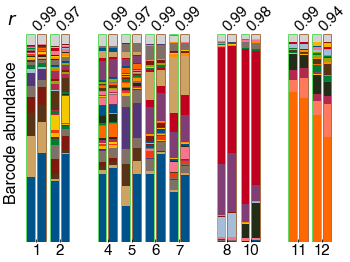

In [37]:
## Cecum feces correlations ##
reload(shared)
expt = 'E1'
rep_mice= [1,2,4,5,6,7,8,10,11,12]
m_spacing = [1,2,4,5,6,7,9,10,12,13]

fig, ax = plt.subplots(1, 1, figsize=(3*2,2*2), frameon=False)

mouse = 1
(fec_day, cec_day) = (54, 'cecum')
_, (fec_reads, cec_reads), (fec_depth, cec_depth) = shared.get_mouse_timecourse(expt, mouse, min_depth=10**4, specific_timepoints=[fec_day, cec_day])
fec_freqs = shared.calc_freqs(fec_reads, fec_depth)
cec_freqs = shared.calc_freqs(cec_reads, cec_depth)

sorting = np.argsort(cec_freqs)[::-1]
for m, mouse in zip(m_spacing, rep_mice):
    # print(shared.mouse_meta[expt][mouse])
    if mouse < 11:
        final_day = 54
    else:
        final_day = 51
    try:
        _, (fec_reads, cec_reads), (fec_depth, cec_depth) = shared.get_mouse_timecourse(expt, mouse, min_depth=10**4, specific_timepoints=[final_day, cec_day])
        fec_freqs = shared.calc_freqs(fec_reads, fec_depth)
        cec_freqs = shared.calc_freqs(cec_reads, cec_depth)


        cec_freqs = cec_freqs[sorting]
        fec_freqs = fec_freqs[sorting]
        large = cec_freqs > 10**-3

        cec_cg = np.zeros(large.sum() + 1)
        fec_cg = np.zeros(large.sum() + 1)
        bc_lst = np.zeros(large.sum() + 1, dtype='int')

        cec_cg[:-1] = cec_freqs[large]
        cec_cg[-1] = cec_freqs[~large].sum()

        fec_cg[:-1] = fec_freqs[large]
        fec_cg[-1] = fec_freqs[~large].sum()

        bc_lst[:-1] = np.arange(fec_reads.shape[0], dtype='int')[sorting][large]

        mask = (fec_cg != 0) * (cec_cg != 0)

        r = np.corrcoef(np.log(fec_cg[mask]), np.log(cec_cg[mask]))[0, 1]
        ax.text(2*m-0.5, 1.02, f'{r:.2f}', fontsize=15, rotation=45)

        width = 0.65
        ax.bar(2*m - 0.45, 1, bottom=0, lw=1.5, edgecolor='limegreen', width=width)
        ax.bar(2*m + 0.45, 1, bottom=0, lw=1.5, edgecolor='saddlebrown', width=width)
        for i, (bc, cec_f, fec_f) in enumerate(zip(bc_lst, cec_cg, fec_cg)):
            if i < large.sum()-1:
                ax.bar(2*m - 0.45, cec_f, bottom=cec_cg[:i].sum(), color=KELLY_COLORS[bc%len(KELLY_COLORS)], width=width)
                ax.bar(2*m + 0.45, fec_f, bottom=fec_cg[:i].sum(), color=KELLY_COLORS[bc%len(KELLY_COLORS)], width=width)
            else:
                ax.bar(2*m - 0.45, cec_f, bottom=cec_cg[:i].sum(), color='lightgrey', width=width)
                ax.bar(2*m + 0.45, fec_f, bottom=fec_cg[:i].sum(), color='lightgrey', width=width)

    except:
        continue

ax.text(-0.5, 1.05, r'$r$', fontsize=18, rotation=0)
ax.text(-0.75, 0.2, r'Barcode abundance', fontsize=16, rotation=90)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0)

ax.set_xticks(2*np.array(m_spacing))
ax.set_xticklabels(rep_mice, fontsize=15)
ax.set_yticks([])
fig.savefig(f'../figures/E1_cecum_feces_barplots.pdf', transparent=True, bbox_inches='tight')
fig.savefig(f'../figures/E1_cecum_feces_barplots.svg', transparent=True, bbox_inches='tight')


In [4]:
def maxmin_freqs(freqs0, depth0, freqs1, depth1):
    overD0 = np.full(freqs0.shape[-1], 1 / depth0)
    overD1 = np.full(freqs1.shape[-1], 1 / depth1)

    min_f0 = np.min([freqs1, overD0], axis=0)
    maxmin_f0 = np.max([freqs0, min_f0], axis=0)

    min_f1 = np.min([freqs0, overD1], axis=0)
    maxmin_f1 = np.max([freqs1, min_f1], axis=0)

    return maxmin_f0, maxmin_f1

def calc_logit(f0, f1):
    return np.log( f1 * (1-f0) / ( f0 * (1-f1)) )

def calc_logit_change(freqs0, freqs1, renorm):
    if np.any(renorm):
        f0_remainder, f1_remainder = renorm

        f0_renormalized = freqs0 / (freqs0 + f0_remainder)
        f1_renormalized = freqs1 / (freqs1 + f1_remainder)

        lfcs = np.log(f1_renormalized * (1-f0_renormalized) / ((1-f1_renormalized) * f0_renormalized) )
        return lfcs
    else:
        # return np.log( freqs1 * (1-freqs0) / (freqs0 * (1-freqs1)))
        return np.log( freqs1 * (1-freqs0) / (freqs0 * (1-freqs1)))

def get_cec_fec_freqs(expt, mice_list):
    paired_freqs, paired_depths = [], []

    for mouse in mice_list:
        final_day = get_last_day(expt, mouse)
        _, (fec_reads, cec_reads), (fec_depths, cec_depths) = shared.get_mouse_timecourse(expt, mouse, min_depth=10**4, specific_timepoints=[final_day, 'cecum'])
        fec_freqs = shared.calc_freqs(fec_reads, fec_depths)
        cec_freqs = shared.calc_freqs(cec_reads, cec_depths)

        paired_freqs.append((fec_freqs, cec_freqs))
        paired_depths.append((fec_depths, cec_depths))
        
    return np.array(paired_freqs), np.array(paired_depths)

def get_cecum_biases(paired_freqs, paired_depths, mice_list, valid_barcode_indices, renorm=True):
    valid_barcodes = shared.barcodes[valid_barcode_indices]
    # paired_depths = paired_reads.sum(axis=2)
    # paired_freqs = np.einsum('ijk, ij->ijk', paired_reads, paired_depths**-1.)

    ## get cecum bia
    cecum_bias_dict = {'barcodes':valid_barcodes, 'indices':valid_barcode_indices}
    for mouse, (cec_f, fec_f), (cec_D, fec_D) in zip(mice_list, paired_freqs, paired_depths):
        cec_subset, fec_subset = cec_f[valid_barcode_indices], fec_f[valid_barcode_indices]

        cec_maxmin, fec_maxmin = shared.maxmin_freqs(cec_subset, cec_D, fec_subset, fec_D)

        renorm_barcodes = np.array([i for i in range(len(shared.barcodes)) if i not in valid_barcode_indices])
        # sub = [i for i in renorm_barcodes if len([base for base in shared.barcodes[i] if base in 'GC']) / len(shared.barcodes[i])  > 0.5]
        f0_remainder = np.sum(fec_f[renorm_barcodes])
        f1_remainder = np.sum(cec_f[renorm_barcodes])

        if renorm:
            bias = calc_logit_change( fec_maxmin, cec_maxmin, renorm=(f0_remainder, f1_remainder))
        else:
            bias = calc_logit_change( fec_maxmin, cec_maxmin, renorm=(1,1))
        # bias = calc_logit_change( fec_maxmin, cec_maxmin, renorm=renorm)
        # bias = np.log(cec_maxmin / fec_maxmin)
        cecum_bias_dict[mouse] = {'bias': bias,
                                  'cec':(cec_subset, cec_f, cec_D),
                                  'fec':(fec_subset, fec_f, fec_D)}
    return cecum_bias_dict


import scipy.stats

def calc_leave_one_out_correlations(lfcs):
    spearman_rsq, spearman_p = [], []
    pearson_rsq, pearson_p = [], []
    for i in range(lfcs.shape[0]):
        leave_one_out = [j for j in range(0, lfcs.shape[0]) if j != i]
        leave_one_out_mean = np.mean(lfcs[leave_one_out], axis=0)

        spearman =  scipy.stats.spearmanr(leave_one_out_mean, lfcs[i])
        pearson = scipy.stats.pearsonr(leave_one_out_mean, lfcs[i])

        spearman_rsq.append(spearman[0]**2)
        spearman_p.append(spearman[1])

        pearson_rsq.append(pearson[0]**2)
        pearson_p.append(pearson[1])

    return list(zip(spearman_rsq, spearman_p)), list(zip(pearson_rsq, pearson_p))

def prep_cecum_biases_for_plotting(bias_ax, freq_ax, cecum_bias_dict, minmax=False,):
    cecum_bias_array = []
    cecum_freq_array = []
    mice = list(key for key in cecum_bias_dict.keys() if type(key) == int )
    for mouse in mice:
        cecum_biases = np.copy(cecum_bias_dict[mouse]['bias'])
        if minmax:
            cecum_biases[ np.abs(cecum_biases) > 1.1 ] = np.sign(cecum_biases[np.abs(cecum_biases) > 1.1]) * 1.1
        cecum_bias_array.append(list(cecum_biases))

        cecum_freqs = cecum_bias_dict[mouse]['cec'][0]
        cecum_freq_array.append(cecum_freqs)
    cecum_bias_array = np.array(cecum_bias_array)
    cecum_freq_array = np.array(cecum_freq_array)

    sorting = np.argsort( np.mean(cecum_bias_array, axis=0) )[::-1]
    # sorting = np.argsort(cecum_bias_array[-1])[::-1]
    # sorting = np.argsort( cecum_bias_array[0] )[::-1]
    # sorting = np.argsort( np.mean(np.log(cecum_freq_array), axis=0) )[::-1]


    return sorting, cecum_bias_array[:, sorting], cecum_freq_array[:, sorting] #calc_leave_one_out_correlations(cecum_bias_array)

0.8040703223499319


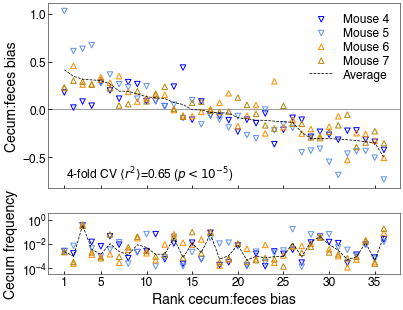

In [5]:
expt = "E1"
mice_set = [4,5,6,7]
# mice_set = [1,2,3,4,5]


paired_freqs, paired_depths = get_cec_fec_freqs(expt, mice_set)
cec_freqs, fec_freqs = paired_freqs[:, 0], paired_freqs[:, 1]


max_freqs = np.min(paired_freqs, axis=1) 
min_freqs = np.min(paired_freqs, axis=1)
max_cutoff = 10**-0
min_cutoff = 10**-4

valid = ((max_freqs > min_cutoff).sum(axis=0) == len(mice_set)) & ((max_freqs < max_cutoff).sum(axis=0) == len(mice_set))
valid_indices = np.arange(len(shared.barcodes))[valid]
valid_barcodes = shared.barcodes[valid]

cecum_bias_dict = get_cecum_biases(paired_freqs, paired_depths, mice_set, valid_indices, renorm=False)
mouse_colors = {1:'tab:blue', 2:'tab:red', 3:'tab:olive', 4:'blue', 5:'cornflowerblue', 
                6:'darkorange', 7:'darkgoldenrod', 8:'tab:blue', 9:'tab:red', 10:'tab:purple',
                11:'tab:red', 12:'tab:purple', 13:'tab:orange', 14:'tab:brown', 15:'tab:purple'}


mouse_marker_map = {1:'o', 2:'o', 3:'o', 4:'v', 5:'v', 6:'^', 7:'^', 8:'s', 9:'s', 10:'s', 11:'o', 12:'s', 13:'^', 14:'>', 15:'<'}



fig = plt.figure(figsize=(0.175*len(cecum_bias_dict['barcodes']),5))
gs = mpl.gridspec.GridSpec(nrows=2, ncols=1, height_ratios=(3,1), hspace=0.2, figure=fig)
bias_ax = fig.add_subplot(gs[0])
freq_ax = fig.add_subplot(gs[1])


sorting, cecum_bias_array, cecum_freq_array = prep_cecum_biases_for_plotting(bias_ax, freq_ax, cecum_bias_dict)

for mouse, cecum_biases, cecum_freqs, color in zip(mice_set, cecum_bias_array, cecum_freq_array, mouse_colors):
        bias_ax.scatter(np.arange(len(cecum_biases))+1, cecum_biases, marker=mouse_marker_map[mouse],
                        edgecolors=mouse_colors[mouse], facecolors='none', label=f'Mouse {mouse}', s=30)
        freq_ax.scatter(np.arange(len(cecum_biases))+1, cecum_freqs, marker=mouse_marker_map[mouse],
                        edgecolors=mouse_colors[mouse], facecolors='none', s=30)
        
bias_ax.plot(np.arange(len(sorting))+1, np.mean(cecum_bias_array, axis=0), color='black', linestyle='dashed', label="Average")
freq_ax.plot(np.arange(len(sorting))+1, np.exp(np.mean(np.log(cecum_freq_array), axis=0)), color='black', linestyle='dashed')

        
sorted_barcodes = cecum_bias_dict['barcodes'][sorting]


### Cross-validation 
rvals, pvals = [], []
for rep in range(len(mice_set)):
        avg_others = np.mean(cecum_bias_array[[i for i in range(len(mice_set)) if i != rep]], axis=0)
        result = scipy.stats.linregress(avg_others, y=cecum_bias_array[rep], alternative='greater')
        rvals.append(result.rvalue)
        pvals.append(result.pvalue)
cv_rval = np.mean(rvals)        
print(cv_rval)

# null_cv_rvals = []
# for _ in range(10**5):
#         shuffled = np.array([rnd.permutation(cecum_bias_array[i]) for i in range(cecum_bias_array.shape[0])])
#         rvals, pvals = [], []
#         for rep in range(len(mice_set)):
#                 avg_others = np.mean(shuffled[[i for i in range(len(mice_set)) if i != rep]], axis=0)
#                 result = scipy.stats.linregress(avg_others, y=shuffled[rep], alternative='greater')
#                 rvals.append(result.rvalue)
#                 pvals.append(result.pvalue)
#         null_cv_rvals.append( np.mean(rvals) )
# null_cv_rvals = np.array(null_cv_rvals)        
# pval = (null_cv_rvals > cv_rval).sum() / len(null_cv_rvals)
# print(pval)


if 'format':
        freq_ax.set_xticks([1,5,10,15,20,25,30,35])
        bias_ax.set_xticks([1,5,10,15,20,25,30,35])
        bias_ax.set_xticklabels(['']*len(bias_ax.get_xticks()))
        # bias_ax.set_ylim(-1.2, 1.2)

        bias_ax.legend(ncol=1, loc=1, frameon=False, fontsize=12, labelspacing=0.15)
        freq_ax.set_yscale('log')
        freq_ax.set_ylim(3*10**-5, 4)
        freq_ax.set_yticks([10**-4, 10**-2, 1])
        bias_ax.axhline(0, color='grey', zorder=0)

        freq_ax.set_xlabel('Rank cecum:feces bias', fontsize=14)
        bias_ax.set_ylabel('Cecum:feces bias', fontsize=14)
        # bias_ax.set_xlabel('Rank cecum:feces bias', fontsize=14)
        freq_ax.set_ylabel('Cecum frequency', fontsize=14)

        # bias_ax.set_xticks([int(i) for i in range(1, len(cecum_bias_dict['barcodes'])+1, 2)])
        # freq_ax.set_xticks([int(i) for i in range(1, len(cecum_bias_dict['barcodes'])+1, 2)])
        # freq_ax.set_xticklabels([int(i) for i in range(1, len(cecum_bias_dict['barcodes'])+1, 2)], fontsize=10)
        for axis in ['top','bottom','left','right']:
            bias_ax.spines[axis].set_linewidth(0.5)
            freq_ax.spines[axis].set_linewidth(0.5)
        #make text with p=10^-5 in scientific form
        bias_ax.text(0.05, 0.05, r'4-fold CV $\langle r^2 \rangle$'+ f"={cv_rval**2:.2f}" + r" ($p<10^{-5}$)", fontsize=12, transform=bias_ax.transAxes)
        

        # bias_ax.set_title(f'Experiment {expt}: M{np.min(mice_set)}-{np.max(mice_set)} feces / cecum ratios (fitnesses)')


plt.rcParams['svg.fonttype'] = 'none'
fig.savefig(f'../figures/fig3_cecum_bias_crosshoused.pdf', bbox_inches='tight', transparent=True)
fig.savefig(f'../figures/fig3_cecum_bias_crosshoused.svg', bbox_inches='tight', transparent=True)


0.8483364093218038
0.0


/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_5662/3116244731.py:87: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bias_ax.set_yticklabels(bias_ax.get_yticklabels(), fontsize=9)
/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_5662/3116244731.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  freq_ax.set_yticklabels(freq_ax.get_yticklabels(), fontsize=9)


0.8669327549476954
0.0


/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_5662/3116244731.py:87: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bias_ax.set_yticklabels(bias_ax.get_yticklabels(), fontsize=9)
/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_5662/3116244731.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  freq_ax.set_yticklabels(freq_ax.get_yticklabels(), fontsize=9)


0.541448132049324
4e-05


/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_5662/3116244731.py:87: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bias_ax.set_yticklabels(bias_ax.get_yticklabels(), fontsize=9)
/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_5662/3116244731.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  freq_ax.set_yticklabels(freq_ax.get_yticklabels(), fontsize=9)


0.12441559988051905
0.22218


/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_5662/3116244731.py:87: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bias_ax.set_yticklabels(bias_ax.get_yticklabels(), fontsize=9)
/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_5662/3116244731.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  freq_ax.set_yticklabels(freq_ax.get_yticklabels(), fontsize=9)


0.6102953304212076
0.031


/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_5662/3116244731.py:87: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bias_ax.set_yticklabels(bias_ax.get_yticklabels(), fontsize=9)
/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_5662/3116244731.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  freq_ax.set_yticklabels(freq_ax.get_yticklabels(), fontsize=9)


0.27097126529451665
0.1506


/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_5662/3116244731.py:87: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bias_ax.set_yticklabels(bias_ax.get_yticklabels(), fontsize=9)
/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_5662/3116244731.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  freq_ax.set_yticklabels(freq_ax.get_yticklabels(), fontsize=9)


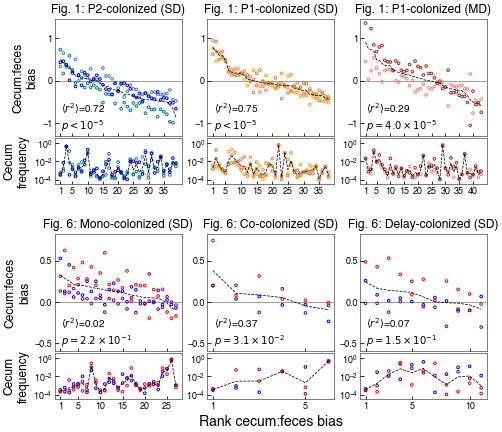

In [38]:
reload(util)
mouse_colors = {'E1': {1:'steelblue', 2:'teal', 3:'blue', 4:'purple', 5:'red', 
                6:'darkorange', 7:'darkgoldenrod', 8:'orange', 9:'coral', 10:'peru', 11:'salmon', 12:'brown'},
                'E2': {3:'blue', 4:'purple', 5:'red', 8:'blue', 9:'purple', 10:'red', 13:'blue', 14:'purple', 15:'red'}   }

mouse_marker_map = {1:'o', 2:'o', 3:'o', 4:'o', 5:'o', 6:'o', 7:'o', 8:'o', 9:'o', 10:'o', 11:'o', 12:'o', 13:'o', 14:'o', 15:'o'}
fig = plt.figure(figsize=(7.75, 7))

gs = mpl.gridspec.GridSpec(nrows=2, ncols=3, height_ratios=(1,1), hspace=0.3, figure=fig)
outer_ax = fig.add_subplot(gs[:, :])
outer_ax.set_xlabel('Rank cecum:feces bias', fontsize=14, labelpad=15)
util.turn_off_ax(outer_ax)



for z, (expt, mice_set, title) in enumerate([('E1', [1,2,3], 'Fig. 1: P2-colonized (SD)'), ('E1', [8,9,10], 'Fig. 1: P1-colonized (SD)'), ('E1', [11,12], 'Fig. 1: P1-colonized (MD)'), 
                                      ('E2', [8,9,10], 'Fig. 6: Mono-colonized (SD)'), ('E2', [3,4,5], 'Fig. 6: Co-colonized (SD)'), ('E2', [13,14,15], 'Fig. 6: Delay-colonized (SD)')]):
        sub_gs = mpl.gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs[z//3, z%3], height_ratios=(2.5,1), hspace=0.02)
        bias_ax = fig.add_subplot(sub_gs[0])
        freq_ax = fig.add_subplot(sub_gs[1])
        bias_ax.set_title(title, fontsize=12)


        paired_freqs, paired_depths = get_cec_fec_freqs(expt, mice_set)
        cec_freqs, fec_freqs = paired_freqs[:, 0], paired_freqs[:, 1]


        max_freqs = np.min(paired_freqs, axis=1) 
        min_freqs = np.min(paired_freqs, axis=1)
        max_cutoff = 10**-0
        min_cutoff = 10**-4

        valid = ((max_freqs > min_cutoff).sum(axis=0) == len(mice_set)) & ((max_freqs < max_cutoff).sum(axis=0) == len(mice_set))
        valid_indices = np.arange(len(shared.barcodes))[valid]
        valid_barcodes = shared.barcodes[valid]


        cecum_bias_dict = get_cecum_biases(paired_freqs, paired_depths, mice_set, valid_indices, renorm=False)
        sorting, cecum_bias_array, cecum_freq_array = prep_cecum_biases_for_plotting(bias_ax, freq_ax, cecum_bias_dict)
        for mouse, cecum_biases, cecum_freqs  in zip(mice_set, cecum_bias_array, cecum_freq_array):
                bias_ax.scatter(np.arange(len(cecum_biases))+1, cecum_biases, marker=mouse_marker_map[mouse],
                                edgecolors=mouse_colors[expt][mouse], facecolors='none', label=f'Mouse {mouse}', s=7)
                freq_ax.scatter(np.arange(len(cecum_biases))+1, cecum_freqs, marker=mouse_marker_map[mouse],
                                edgecolors=mouse_colors[expt][mouse], facecolors='none', s=7)
                
        bias_ax.plot(np.arange(len(sorting))+1, np.mean(cecum_bias_array, axis=0), color='black', linestyle='dashed', label="Average")
        freq_ax.plot(np.arange(len(sorting))+1, np.exp(np.mean(np.log(cecum_freq_array), axis=0)), color='black', linestyle='dashed')

        

        sorted_barcodes = cecum_bias_dict['barcodes'][sorting]


        ### Cross-validation 
        rvals, pvals = [], []
        for rep in range(len(mice_set)):
                avg_others = np.mean(cecum_bias_array[[i for i in range(len(mice_set)) if i != rep]], axis=0)
                result = scipy.stats.linregress(avg_others, y=cecum_bias_array[rep], alternative='greater')
                rvals.append(result.rvalue)
                pvals.append(result.pvalue)
        cv_rval = np.mean(rvals)        
        print(cv_rval)

        null_cv_rvals = []
        for _ in range(10**5):
                shuffled = np.array([rnd.permutation(cecum_bias_array[i]) for i in range(cecum_bias_array.shape[0])])
                rvals, pvals = [], []
                for rep in range(len(mice_set)):
                        avg_others = np.mean(shuffled[[i for i in range(len(mice_set)) if i != rep]], axis=0)
                        result = scipy.stats.linregress(avg_others, y=shuffled[rep], alternative='greater')
                        rvals.append(result.rvalue)
                        pvals.append(result.pvalue)
                null_cv_rvals.append( np.mean(rvals) )
        null_cv_rvals = np.array(null_cv_rvals)        
        pval = (null_cv_rvals > cv_rval).sum() / len(null_cv_rvals)
        print(pval)


        if 'format':
                if z < 3:
                        bias_ax.set_ylim(-1.3, 1.45)
                else:
                        bias_ax.set_ylim(-0.6, 0.825)
                freq_ax.set_xticks([1]+[5*i for i in range(1, len(cecum_bias_dict['barcodes'])//5+1)])
                bias_ax.set_xticks([1]+[5*i for i in range(1, len(cecum_bias_dict['barcodes'])//5+1)])
                bias_ax.set_xticklabels(['']*len(bias_ax.get_xticks()), fontsize=9)
                bias_ax.set_yticklabels(bias_ax.get_yticklabels(), fontsize=9)
                freq_ax.set_xticklabels(freq_ax.get_xticklabels(), fontsize=9)
                freq_ax.set_yticklabels(freq_ax.get_yticklabels(), fontsize=9)
                # bias_ax.set_ylim(-1.2, 1.2)

                
                freq_ax.set_yscale('log')
                freq_ax.set_ylim(2*10**-6, 4)
                bias_ax.axhline(0, color='grey', zorder=0)

                freq_ax.set_ylim(3*10**-5, 4)
                freq_ax.set_yticks([10**-4, 10**-2, 1])
                

                if z % 3 == 0:
                        bias_ax.set_ylabel('Cecum:feces\nbias', fontsize=12)
                        freq_ax.set_ylabel('Cecum\nfrequency', fontsize=12)

                # bias_ax.set_xticks([int(i) for i in range(1, len(cecum_bias_dict['barcodes'])+1, 2)])
                # freq_ax.set_xticks([int(i) for i in range(1, len(cecum_bias_dict['barcodes'])+1, 2)])
                # freq_ax.set_xticklabels([int(i) for i in range(1, len(cecum_bias_dict['barcodes'])+1, 2)], fontsize=10)
                for axis in ['top','bottom','left','right']:
                        bias_ax.spines[axis].set_linewidth(0.5)
                        freq_ax.spines[axis].set_linewidth(0.5)
                #make text with p=10^-5 in scientific form

                # bias_ax.legend(ncol=1, loc=1, frameon=False, fontsize=12, labelspacing=0.15)
                if pval == 0:
                        bias_ax.text(0.05, 0.05, r'$\langle r^2 \rangle$'+ f"={cv_rval**2:.2f}" + f"\n$p<10^{{-5}}$", fontsize=10, transform=bias_ax.transAxes)
                else:
                        bias_ax.text(0.05, 0.05, r'$\langle r^2 \rangle$'+ f"={cv_rval**2:.2f}" + f"\n$p={util.as_si(pval,1)}$", fontsize=10, transform=bias_ax.transAxes)

                # bias_ax.set_title(f'Experiment {expt}: M{np.min(mice_set)}-{np.max(mice_set)} feces / cecum ratios (fitnesses)')


plt.rcParams['svg.fonttype'] = 'none'
fig.savefig(f'../figures/sfig_cecum_bias_other_cages.pdf', bbox_inches='tight', transparent=True)
fig.savefig(f'../figures/sfig_cecum_bias_other_cages.svg', bbox_inches='tight', transparent=True)

0.8398992128847138
0.7766417250707525
0.38369709594234025
0.468836766572458


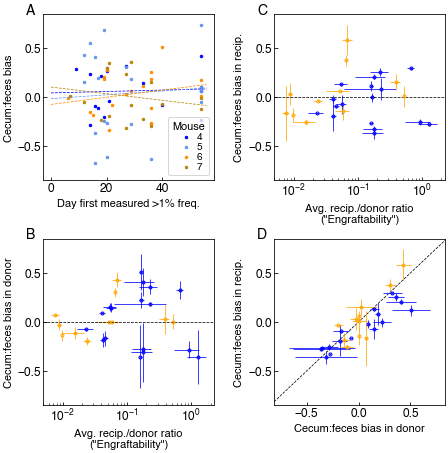

In [24]:
## are barcodes that fail to engraft still deteceted in cecum? 

## sort by "Engraftability"
## plot probability of detection in cecum (i.e. detected in both mice?)
## Just need a bit of Fig 2 data...
reload(shared)
def nan_fn(x, fn):
    if np.isnan(x).all():
        return np.nan
    else:
        return fn(x)
    
expt = 'E1'

with open(f'{data_dir}/pickled/E1_large_barcode_migration_ratios.pkl', 'rb') as f:
    large_barcode_migration_ratios = pickle.load(f)

fig = plt.figure(figsize=(7.2,7.2))
gs = mpl.gridspec.GridSpec(2, 2, height_ratios=[1, 1], wspace=0.35, hspace=0.35, figure=fig)

# gs = mpl.gridspec.GridSpec(1, 3, wspace=0.45, figure=fig)

timing_ax = fig.add_subplot(gs[0, 0])
for mouse in range(4,8): #exclude mouse 13
    timepoints,reads, depths = shared.get_mouse_timecourse(expt, mouse, min_depth=10**4)
    freqs = shared.calc_freqs(reads, depths)
    large_barcodes_bool = np.max(freqs, axis=0) > 1e-2
    large_barcodes = np.arange(len(shared.barcodes))[large_barcodes_bool]

    time_reaching_1p, cecum_bias = [], []

    if mouse > 10:
        _, (fec_reads, cec_reads), (fec_depth, cec_depth) = shared.get_mouse_timecourse(expt, mouse, min_depth=10**4, specific_timepoints=[51, 'cecum'])
    else:
        _, (fec_reads, cec_reads), (fec_depth, cec_depth) = shared.get_mouse_timecourse(expt, mouse, min_depth=10**4, specific_timepoints=[54, 'cecum'])
    fec_freqs = shared.calc_freqs(fec_reads, fec_depth)
    cec_freqs = shared.calc_freqs(cec_reads, cec_depth)
    
    for barcode_index in large_barcodes:
        if shared.barcodes[barcode_index] not in sorted_barcodes:
            continue
        time = timepoints[np.where(freqs[:, barcode_index] > 1e-2)[0][0]]

        time_reaching_1p.append(time)
        cecum_bias.append( np.log( cec_freqs[barcode_index] / fec_freqs[barcode_index] ) )
    
    time_reaching_1p, cecum_bias = np.array(time_reaching_1p), np.array(cecum_bias)
    timing_ax.scatter(time_reaching_1p, cecum_bias, s=6, color=mouse_colors[mouse], label=f'{mouse}')
    notnan = ~np.isnan(cecum_bias) & ~np.isinf(cecum_bias)
    linregress = scipy.stats.linregress(time_reaching_1p[notnan], cecum_bias[notnan])
    print(linregress.pvalue)
    timing_ax.plot([0, 56], [linregress.intercept, 56*linregress.slope + linregress.intercept], linestyle='--', color=mouse_colors[mouse])
timing_ax.set_xlabel('Day first measured >1% freq.', fontsize=11)
timing_ax.set_ylabel('Cecum:feces bias', fontsize=11)
timing_ax.legend(title="Mouse", loc=4, ncol=1, title_fontsize=11, fontsize=10, frameon=True, labelspacing=0.1, handletextpad=0.05, columnspacing=0.1)


donor_bias_ax = fig.add_subplot(gs[1,0])
recip_bias_ax = fig.add_subplot(gs[0,1])
bias_vs_bias_ax = fig.add_subplot(gs[1,1])



x, y = [], []
for barcode, recip_donor_ratios in large_barcode_migration_ratios.items():
    if shared.barcodes[barcode] not in sorted_barcodes:
        continue

    donor = recip_donor_ratios['donor']
    recip_ratios = recip_donor_ratios['recips']

    if donor in [4,5]:
        donors = [4,5]
        c = 'blue'
    else:
        donors = [6,7]
        c = 'orange'

    # freq ax
    pseudo = 1e-7
    donor_biases = []
    donor_final_freqs = []
    for donor in donors:
        _, (fec_reads, cec_reads), (fec_depth, cec_depth) = shared.get_mouse_timecourse(expt, donor, min_depth=10**5, specific_timepoints=[54, 'cecum'])
        fec_donor = shared.calc_freqs(fec_reads, fec_depth)[barcode]
        cec_donor = shared.calc_freqs(cec_reads, cec_depth)[barcode]

        with np.errstate(divide='ignore'): donor_biases.append( np.log(cec_donor/fec_donor) )
        donor_final_freqs.append(fec_donor)


    recip_biases = []
    for (recip, ratio) in recip_ratios:
        _, (fec_reads, cec_reads), (fec_depth, cec_depth) = shared.get_mouse_timecourse(expt, recip, min_depth=10**5, specific_timepoints=[54, 'cecum'])
        fec_freq = shared.calc_freqs(fec_reads, fec_depth)[barcode]
        cec_freq = shared.calc_freqs(cec_reads, cec_depth)[barcode]

        freq_ax.scatter(fec_freq + pseudo, cec_freq + pseudo, color=c, s=15, marker='o', facecolor='none')
        with np.errstate(divide='ignore'): recip_biases.append( np.log(cec_freq/fec_freq) )

    recip_biases = np.array(recip_biases)
    donor_biases = np.array(donor_biases)
    
    ratios = [ratio for (recip, ratio) in recip_ratios]
    ratios = np.array(ratios)

    mean_ratio, ratio_err = nan_fn(ratios, np.nanmean), nan_fn(ratios, np.nanstd)
    mean_donor_bias, donor_bias_err = nan_fn(donor_biases, np.nanmean), nan_fn(donor_biases, np.nanstd)
    mean_recip_bias, recip_bias_err = nan_fn(recip_biases, np.nanmean), nan_fn(recip_biases, np.nanstd)

    donor_bias_ax.errorbar(mean_ratio, mean_donor_bias, xerr=ratio_err, yerr=donor_bias_err, color=c, marker='o', mfc='none', markersize=3)
    recip_bias_ax.errorbar(mean_ratio, mean_recip_bias, xerr=ratio_err, yerr=recip_bias_err, color=c, marker='o', mfc='none', markersize=3)
    bias_vs_bias_ax.errorbar(mean_donor_bias, mean_recip_bias, xerr=donor_bias_err, yerr=recip_bias_err, color=c, marker='o', mfc='none', markersize=3)
    x.append(mean_donor_bias)
    y.append(mean_recip_bias)
    # recip_bias_ax.errorbar(np.mean(x), np.mean(y), xerr=np.abs(np.diff(x))/2, yerr=np.abs(np.diff(y))/2, color=c, marker='o', mfc='none')

x, y = np.array(x), np.array(y)
notinf = (~np.isinf(x)) & (~np.isinf(y)) & (~np.isnan(x)) & (~np.isnan(y))

for ax in [donor_bias_ax, recip_bias_ax, bias_vs_bias_ax]:
    ax.set_xscale('log')
    # ax.set_yscale('log')
    ax.set_facecolor('white')
    ax.set_ylim(-0.85, 0.85)
# freq_ax.set_xscale('log')
# freq_ax.set_yscale('log')
timing_ax.set_ylim(-0.85, 0.85)
bias_vs_bias_ax.set_xscale('linear')


freq_ax.set_xlabel('Freq. in recip. feces, day 54', fontsize=11)
freq_ax.set_ylabel('Freq. in recip. cecum, day 54', fontsize=11)
util.plot_diagonal(freq_ax)
util.plot_diagonal(bias_vs_bias_ax)

donor_bias_ax.axhline(0, color='k', linestyle='--')
recip_bias_ax.axhline(0, color='k', linestyle='--')

donor_bias_ax.set_xlabel('Avg. recip./donor ratio\n("Engraftability")', fontsize=11)
recip_bias_ax.set_xlabel('Avg. recip./donor ratio\n("Engraftability")', fontsize=11)
donor_bias_ax.set_ylabel('Cecum:feces bias in donor', fontsize=11)
recip_bias_ax.set_ylabel('Cecum:feces bias in recip.', fontsize=11)

bias_vs_bias_ax.set_xlabel('Cecum:feces bias in donor', fontsize=11)
bias_vs_bias_ax.set_ylabel('Cecum:feces bias in recip.', fontsize=11)

# donor_bias_ax.axline( (10**-3, 10**0),(10**0, 10**-1), color='green')
# recip_bias_ax.axline( (10**-3, 10**-1),(10**-2, 10**-1), color='green')
# bias_vs_bias_ax.axline( (7*10**-1, 7*10**-2),(2, 2*10**-1) , color='green')

timing_ax.text(-0.1, 1.0, 'A', fontsize=14, transform=timing_ax.transAxes)
donor_bias_ax.text(-0.1, 1.0, 'B', fontsize=14, transform=donor_bias_ax.transAxes)
recip_bias_ax.text(-0.1, 1.0, 'C', fontsize=14, transform=recip_bias_ax.transAxes)
bias_vs_bias_ax.text(-0.1, 1.0, 'D', fontsize=14, transform=bias_vs_bias_ax.transAxes)

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig(f'../figures/E1_cecum_vs_engraftment.pdf', format='pdf', transparent=True)
fig.savefig(f'../figures/E1_cecum_vs_engraftment.svg', format='svg', transparent=True)

[0, 1, 2, 3, 4, 5, 6, 7, 9, 14, 16, 17, 18, 19, 20, 21, 22, 27, 29, 33, 36, 40, 54, 'cecum']
0.6858969823149605
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 14, 16, 17, 18, 19, 20, 21, 22, 27, 29, 33, 36, 40, 54, 'cecum']
0.5507855851717869
[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 27, 29, 33, 36, 40, 54, 'cecum']
0.8010070645498157
[0, 1, 3, 4, 5, 6, 7, 9, 12, 15, 16, 17, 18, 19, 20, 21, 22, 27, 29, 33, 36, 40, 54, 'cecum']
0.7108737313095996


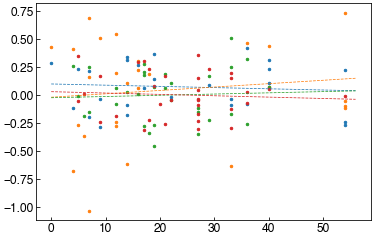

: 

In [232]:
expt = 'E1'

fig, ax = plt.subplots()
for mouse in range(4,8): #exclude mouse 13
    print(list(shared.library_meta[expt][mouse].keys()))
    timepoints,reads, depths = shared.get_mouse_timecourse(expt, mouse, min_depth=10**4)
    freqs = shared.calc_freqs(reads, depths)
    large_barcodes_bool = np.max(freqs, axis=0) > 1e-3
    large_barcodes = np.arange(len(shared.barcodes))[large_barcodes_bool]

    time_reaching_1p, cecum_bias = [], []

    if mouse > 10:
        _, (fec_reads, cec_reads), (fec_depth, cec_depth) = shared.get_mouse_timecourse(expt, mouse, min_depth=10**4, specific_timepoints=[51, 'cecum'])
    else:
        _, (fec_reads, cec_reads), (fec_depth, cec_depth) = shared.get_mouse_timecourse(expt, mouse, min_depth=10**4, specific_timepoints=[54, 'cecum'])
    fec_freqs = shared.calc_freqs(fec_reads, fec_depth)
    cec_freqs = shared.calc_freqs(cec_reads, cec_depth)
    
    for barcode_index in large_barcodes:
        if shared.barcodes[barcode_index] not in sorted_barcodes:
            continue
        time = timepoints[np.where(freqs[:, barcode_index] > 1e-3)[0][0]]

        time_reaching_1p.append(time)
        cecum_bias.append( np.log( cec_freqs[barcode_index] / fec_freqs[barcode_index] ) )
    
    time_reaching_1p, cecum_bias = np.array(time_reaching_1p), np.array(cecum_bias)
    ax.scatter(time_reaching_1p, cecum_bias, s=6)
    notnan = ~np.isnan(cecum_bias) & ~np.isinf(cecum_bias)
    linregress = scipy.stats.linregress(time_reaching_1p[notnan], cecum_bias[notnan])
    print(linregress.pvalue)
    ax.plot([0, 56], [linregress.intercept, 56*linregress.slope + linregress.intercept], linestyle='--')
    



       